In [28]:
import pandas as pd 
import numpy as np
import json 
import matplotlib.pyplot as plt 
import seaborn as sn
import os
import sys 
sys.path.append('..')
from src.hyperpharmacophore import DistanceHyperpharmacophore
from src.molecule_tools import SDFReader
from src.utils import make_activity_plot
from sklearn.metrics import mean_squared_error, r2_score

In [3]:
target = 'CDK2'

In [4]:
# load results 
df = pd.read_csv('data/crystalStructuresProcessed/{}/predictions.csv'.format(target), index_col=0)
df

,yTrue,yPredInt,yPredLig,alignmentScoreInt,alignmentScoreLig
5mhq,6.958607,4.879049,5.356955,0.578164,0.977967
5jq5,5.630599,0.000000,6.681624,0.000000,0.810559
2a4l,6.397940,5.205147,4.889940,0.348609,0.980633
3py0,6.886057,0.000000,6.235997,0.000000,0.712665
3pxy,5.229148,0.000000,5.022967,0.000000,0.855120
3wbl,4.638272,0.000000,4.986358,0.000000,0.732737
3ig7,7.200659,0.000000,5.153976,0.000000,0.711446
3igg,7.177178,5.595599,5.026721,0.570335,0.717085
2c6i,4.958607,0.000000,5.916700,0.000000,0.719345
3qtq,5.508638,5.210315,5.467433,0.705160,0.847278


In [32]:
predictedPdbs = df[(df.yPredInt != 0)].index
yTrue = df.loc[predictedPdbs].yTrue.values
yPred = df.loc[predictedPdbs].yPredInt.values
rmseInt = mean_squared_error(yTrue, yPred, squared=False)
r2Int = r2_score(yTrue, yPred)
rmseInt, r2Int

(1.3591648745695109, -2.376272001429509)

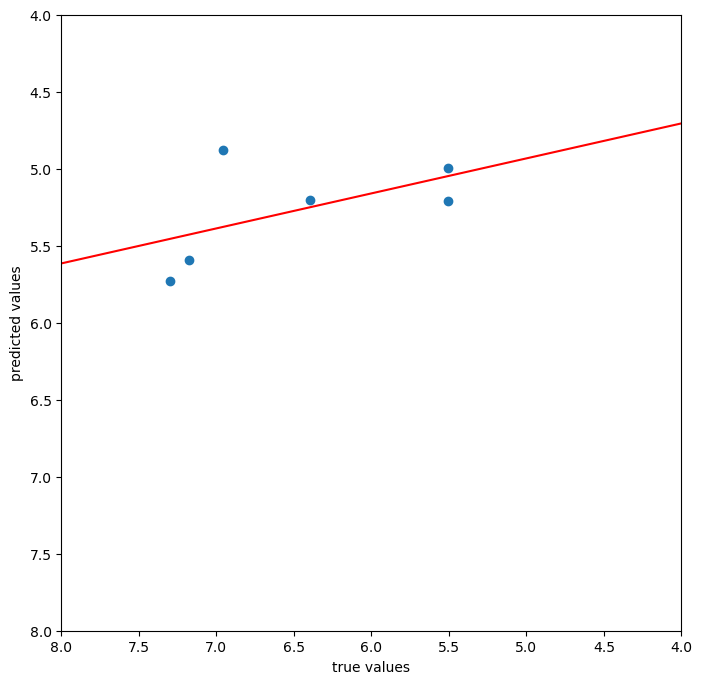

In [33]:
fig, ax = make_activity_plot(yTrue, yPred)
plt.show()
plt.close()

In [34]:
predictedPdbs = df[(df.yPredLig != 0)].index
yTrue = df.loc[predictedPdbs].yTrue.values
yPred = df.loc[predictedPdbs].yPredLig.values
rmseLig = mean_squared_error(yTrue, yPred, squared=False)
r2Lig = r2_score(yTrue, yPred)
rmseLig, r2Lig

(1.3264781098596699, -0.9397281371289246)

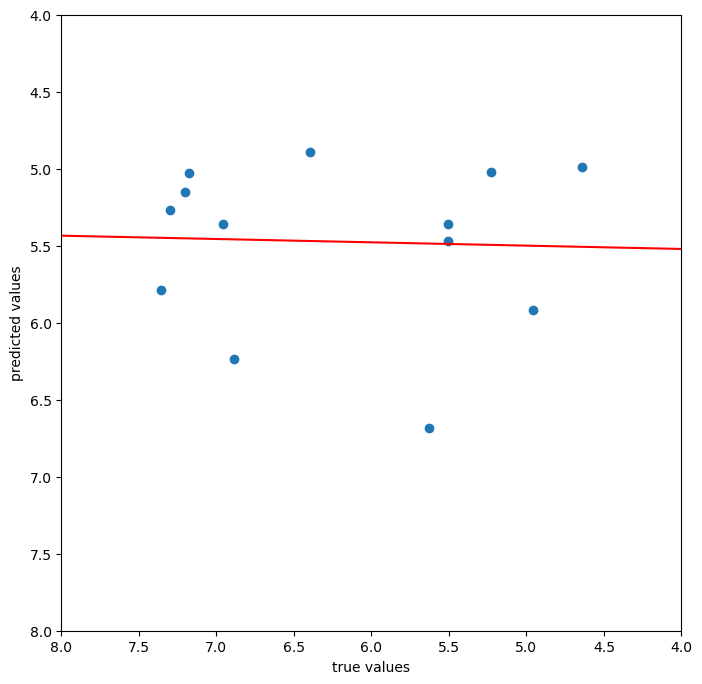

In [35]:
fig, ax = make_activity_plot(yTrue, yPred)
plt.show()
plt.close()

In [20]:
# calculate conformations for ligands
for pdbCode in df.index.values:
    _input = 'data/crystalStructuresProcessed/{}/{}/ligands.sdf'.format(target, pdbCode)
    _output = 'data/crystalStructuresProcessed/{}/{}/ligands_conformations.sdf'.format(target, pdbCode)
    os.system('/opt/ligandscout4/iconfgen -i {} -o {} -n 25'.format(_input, _output))

In [21]:
# load qphar model and predict ligand with conformation
model = DistanceHyperpharmacophore()
model.load('data/models/{}/model/'.format(target))

Loading HP model from data/models/CDK2/model/


/home/stefan/miniconda3/envs/qphar/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator DecisionTreeRegressor from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(
/home/stefan/miniconda3/envs/qphar/lib/python3.8/site-packages/sklearn/base.py:310: UserWarning: Trying to unpickle estimator RandomForestRegressor from version 0.22.1 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


In [23]:
ligands = []
for pdbCode in df.index.values: 
    r = SDFReader('data/crystalStructuresProcessed/{}/{}/ligands_conformations.sdf'.format(target, pdbCode))
    ligands.append(r.read())
    
len(ligands)

13

In [24]:
df.shape

(13, 5)

In [36]:
yPred, alignmentScores, mlFeatures, alignedPharmacophores = model.predict(ligands, returnScores=True, returnFeatureData=True, returnAlignedPharmacophores=True)

In [37]:
yPred

array([6.07794883, 5.36739469, 5.54598312, 5.0028451 , 4.83100431,
       6.13102805, 5.86179274, 5.73602849, 5.78626317, 5.87505265,
       6.25841503, 4.70494404, 5.67766913])

In [38]:
rmse = mean_squared_error(df.yTrue.values, yPred, squared=False)
r2 = r2_score(df.yTrue.values, yPred)
rmse, r2

(1.134912521203968, -0.41992519615494395)

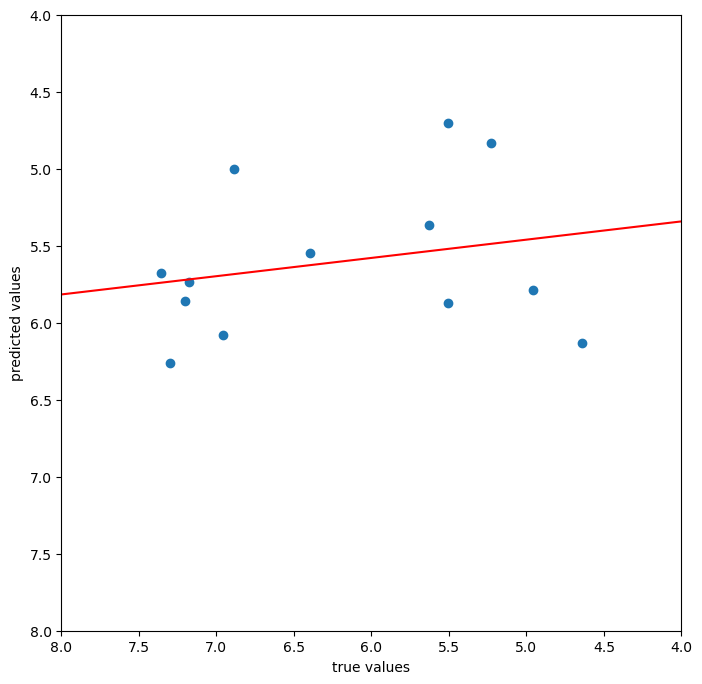

In [39]:
fig, ax = make_activity_plot(df.yTrue.values, yPred)
plt.show()
plt.close()